# **Sales forecast data exploration**
This dataset was a test task for building a sales forecast for the month (March 2020).
We have historical data for 2 full years, as well as 1 quarter of 2020.
The dataset was provided by "Zolotoe Yabloko" store and shows sales for two brands across three stores.

**Content**

There are 4 files in a dataset:

* sales_train - sales for the period from 2018.01.01 to 2019.03.31
* Items - this table contains common information on brands
* stock - this file contains count of days with zero balance for items
* test_submission - a sample of what the final file should look like.


---


**TODO**
Firs, we shod look at the data inside and make some data explorations, visualizations and preprocessing for further usage for statistical or machine learning models for solving a forecasting task.
The things we should do with data:
* Carry out preprocessing of data (search for anomalies, removal / cut of outliers, etc.). Conduct time series analysis (graphical presentation, descriptive statistics).
* Summarize the results of the cleaning, data preprocessing. Draw conclusions based on our analysis.
* Feature engineering
* Correlation Matrix
* Converting categorical features

**Tools**

The next tools and libraries we will use:

* Pandas
* Numpy
* Matplotlib
* Seaborn

These instruments and data analysis techniques were learned from the course "Data Analysis with Python: Zero to Pandas" (zerotopandas.com). 
From the course I've learned, where to search for data, how to load it, how to prepare and visualize it, using Numpy, Pandas and Matplotlib and Seaborn libraries.

## Downloading the Dataset

We will use our own dataset, loaded to Kaggle and set as public dataset for everyone could use it. 

First, we should download our kaggle.json file on a disk. After that, we shold execute next commands to replace kaggle.json to the right path. And it is also needed to open access to the folder.



In [2]:
from google.colab import files
files.upload()  # upload your kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!rm -rf kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


Let's begin by downloading the data, and listing the files within the dataset.

In [3]:
# Download a dataset
!kaggle datasets download -d maxinstellar/forecasting-task
# Unzip data files from 
!unzip -q forecasting-task && rm -rf forecasting-task.zip
!ls

!rm -rf forecasting-task.zip
# Make a directory for data files
!mkdir sales-forecast-dataset

  0% 0.00/5.51M [00:00<?, ?B/s]
100% 5.51M/5.51M [00:00<00:00, 50.9MB/s]
items.csv  sales_train.xlsx  sample_data  stock.xlsx  test_submission.csv


# Remove all unzipped files into data folder:

In [4]:
# Remove all unzipped files into data folder:
!mv sales_train.xlsx /content/sales-forecast-dataset/sales_train.xlsx
!mv items.csv /content/sales-forecast-dataset/items.csv
!mv stock.xlsx /content/sales-forecast-dataset/stock.xlsx
!mv test_submission.csv /content/sales-forecast-dataset/test_submission.csv

In [5]:
# Data directory
data_dir = './sales-forecast-dataset'

In [6]:
import os

os.listdir(data_dir)

['items.csv', 'sales_train.xlsx', 'test_submission.csv', 'stock.xlsx']

Let us save and upload our work to Jovian before continuing.

In [7]:
project_name = "sales-forecast-data-exploration"

In [8]:
!pip install jovian --upgrade -q

In [9]:
import jovian

In [10]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'

## Data Preparation and Cleaning

Carry out preprocessing of data (search for anomalies, removal / cut of outliers, etc.). Conduct time series analysis (graphical presentation, descriptive statistics).
Summarize the results of the cleaning, data preprocessing. Draw conclusions based on our analysis.


In [11]:
# Import libraries for working with tables, arrays
import pandas as pd
import numpy as np

In [12]:
# Name of the data file
# of sales for the period from 2018.01.01 for 2019.03.31
sales_train_df_name = os.path.join(data_dir, "sales_train.xlsx")
sales_train_df = pd.read_excel(sales_train_df_name)

# brand information
items_df_name = os.path.join(data_dir, "items.csv")
items_df = pd.read_csv(items_df_name, sep=';', encoding='cp1251')

# table with the number of days in a month,
# when inventory balances are missing (sold out)
stock_df_name = os.path.join(data_dir, "stock.xlsx")
stock_df = pd.read_excel(stock_df_name)

# example of making a forecast - file "test_submission.csv"
# Actually, we will not use this file - so, there is no sense
# in loading it

In [13]:
print(f"Dataset 'sales_train' has {sales_train_df.shape[0]} raws and {sales_train_df.shape[1]} columns")
sales_train_df.head(5)

Dataset 'sales_train' has 99814 raws and 15 columns


,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0


store code, product code, brand code, shop_id, item_id, promo, brand_id, spec_promo are categorical attributes

In [14]:
print(f"Dataset 'items_df' has {items_df.shape[0]} raws and {items_df.shape[1]} columns")
items_df.head(3)

Dataset 'items_df' has 1367 raws and 4 columns


,item_id,brand_id,item_category_id,item_category
0,20224176006,10013,444,Макияж
1,20221040001,10013,444,Макияж
2,20221376004,10013,444,Макияж


To find out, of what data types items_df columns, we can use .dtypes property:

In [15]:
items_df.dtypes

item_id             object
brand_id             int64
item_category_id     int64
item_category       object
dtype: object

So, we have some Russian words in, we should replace them - prepare dict with words for replacing, and just using .replace() method

In [16]:
# See all unique words in a item_category column: 
makeup_items_rus = items_df['item_category'].unique().tolist()
# See all unique words in a item_category column: 
makeup_items_eng = ['makeup', 'perfume', 'grooming', 'hair_care']
# Form a word-to-word dict
makeup_items_dict = dict([(makeup_items_rus[i], makeup_items_eng[i]) for i in range(len(makeup_items_rus))])

# Use replace() method to replace Russian word to English ones
items_df['item_category'] = items_df['item_category'].replace(makeup_items_dict)

# Check, if we replaced all items
print(f"Unique items: {items_df['item_category'].unique().tolist()}")
items_df.head(3)

Unique items: ['makeup', 'perfume', 'grooming', 'hair_care']


,item_id,brand_id,item_category_id,item_category
0,20224176006,10013,444,makeup
1,20221040001,10013,444,makeup
2,20221376004,10013,444,makeup


In [17]:
print(f"Dataset 'stock_df' has {stock_df.shape[0]} raws and {stock_df.shape[1]} columns")
stock_df.head(3)

Dataset 'stock_df' has 17678 raws and 5 columns


,store,month,days with 0 balance,year,itemid
0,128,9,3,2018,15799504008
1,111,9,2,2018,15816752002
2,128,12,1,2018,35865312103


Just create 2 new columns with 0 values

In [18]:
sales_train_df[['item_category_id', 'item_category']] = 0
sales_train_df.head(3)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,item_category
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,0,0
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,0,0
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,0,0


Trying to make 'item_id' column as numeric will break

In [19]:
# items_df['item_id'] = pd.to_numeric(items_df['item_id'])
# ValueError: Unable to parse string "#Н/Д" at position 535

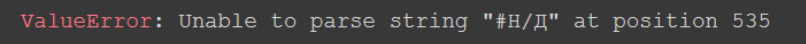

So, we should delete this string, just filtering 'item_id' column with "!= '#Н/Д'" condition:

In [20]:
# Filter items_df
items_df = items_df[items_df['item_id'] != '#Н/Д']
# Convert 'item_id' column to numeric, using pd.to_numeric() method
items_df['item_id'] = pd.to_numeric(items_df['item_id'])

# Check, if 'item_id' column became numeric
items_df.dtypes

item_id              int64
brand_id             int64
item_category_id     int64
item_category       object
dtype: object

In [21]:
from tqdm.notebook import tqdm

# Extract the corresponding item_id to item_category_id
items_df_dict_id = dict([(items_df.iloc[i]['item_id'], 
                          items_df.iloc[i]['item_category_id']) 
                            for i in range(items_df.shape[0])])
# print(items_df_dict_id)  # {20224176006: 444, ... etc.}

# Extract the corresponding item_id to item_category
items_df_dict_category = dict([(items_df.iloc[i]['item_id'], 
                                items_df.iloc[i]['item_category']) 
                                    for i in range(items_df.shape[0])])
# print(items_df_dict_category)  # {20224176006: 'makeup',  ... etc.}

item_category_id, item_category = [], []

for item_id in tqdm(sales_train_df['item_id'].tolist()):
    if item_id in items_df_dict_id.keys():  # Check if category in a dict keys
        item_category_id.append(items_df_dict_id[item_id])
    else:
        item_category_id.append(0)  # For unknown category set 0
    if item_id in items_df_dict_category.keys():  # Check if category in a dict keys
        item_category.append(items_df_dict_category[item_id])
    else:
        item_category.append(0)  # For unknown category set 0
    
# Input data into table
sales_train_df['item_category_id'] = item_category_id
sales_train_df['item_category'] = item_category

# Group the table by item_category_id
# See that for 406 items we don't know the category type:
sales_train_df.groupby('item_category_id').count()

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category
item_category_id,,,,,,,,,,,,,,,,
0,406,406,406,406,406,406,406,406,406,406,406,406,406,406,406,406
333,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019,4019
444,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886,49886
555,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099,45099
666,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404,404


So, we don't need items_df anymore theese information was added into sales_train_df in the last ones two columns

In [22]:
# rename sales_train_df to a simple df
df = sales_train_df
df.head(3)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,item_category
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444,makeup
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444,makeup
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333,perfume


In [23]:
stock_df.head(3)

,store,month,days with 0 balance,year,itemid
0,128,9,3,2018,15799504008
1,111,9,2,2018,15816752002
2,128,12,1,2018,35865312103


Days with 0 balance unique values

In [24]:
stock_df['days with 0 balance'].unique()

array([ 3,  2,  1, 30, 10, 31,  4,  7, 25, 11,  9, 19, 22, 14,  6,  5, 13,
       15, 26, 29, 17, 28,  8, 12, 20, 16, 21, 18, 24, 23, 27])

In [25]:
stock_df.dtypes

store                  int64
month                  int64
days with 0 balance    int64
year                   int64
itemid                 int64
dtype: object

In [26]:
type(df.iloc[1]['item_id'])

numpy.int64

Add data 'days with 0 balance' from stock_df to df dataframe

In [27]:
# Create free list for days saving
days = []

# This code works very slow - it's because of python for cycle,
# not pandas internal functions, or numpy arrays - using them are
# preferable
for i in tqdm(range(df.shape[0])):  # tqdm shows the processing of cycle
    # Filter elements
    store = df.iloc[i]['shop_id']
    month = df.iloc[i]['Month']
    year = df.iloc[i]['Year']
    itemid = df.iloc[i]['item_id']
    # Take value of 'days with 0 balance' column
    day = stock_df['days with 0 balance'][  # filter values
                    (stock_df['store'] == store) &
                    (stock_df['month'] == month) &
                    (stock_df['year'] == year) &
                    (stock_df['itemid'] == itemid)]
    # Check if day exists
    if len(day) != 0:
        # print(day.values[0])
        days.append(day.values[0])
    else:
        # We believe that there were no days 
        # when the product was not sold
        days.append(0)
# Add new column to df dataframe with name 'days_with_0_balance':
df['days_with_0_balance'] = days
df.head(5)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,item_category,days_with_0_balance
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444,makeup,0
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444,makeup,0
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333,perfume,0
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0,444,makeup,0
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0,444,makeup,0


It is not very clear, but maybe it's not a bad one idea to add a new column - number of days, last from the beggining of the year

In [28]:
def days(date, year_num):
    # Function to make a calculus for a day according to 
    return (date // 1000000000 - 1514764800) // 86400 + 1 - 365 * year_num

# Count days for every row in a df
days_2018 = [days(date, 0) for date in df['date'][df['Year']  == 2018].values.tolist()]
days_2019 = [days(date, 1) for date in df['date'][df['Year']  == 2019].values.tolist()]
days_2020 = [days(date, 2) for date in df['date'][df['Year']  == 2020].values.tolist()]

# Concatenate all days values
df['days_from_beginning'] = days_2018 + days_2019 + days_2020
df.head(5)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,item_category,days_with_0_balance,days_from_beginning
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444,makeup,0,1
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444,makeup,0,1
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333,perfume,0,1
3,2018-01-01,1,2018,0,1,111,20221376004,10013,1,139,0,0,0,0,0,444,makeup,0,1
4,2018-01-01,1,2018,0,1,111,20221040001,10013,1,135,0,0,0,0,0,444,makeup,0,1


Analyze discamount column - there are some values, that are below zero

In [29]:
print(df['discamount'][df['discamount'] < 0].unique())

[ -73 -111 -109  -19  -22 -160 -163 -176 -248 -101  -71 -434  -67 -325
 -128 -225 -394 -152 -310   -4 -229 -190  -79  -95 -212  -11 -230 -199
  -50 -189 -118 -164 -150 -723 -391 -226 -235 -409 -716 -249  -62  -59
 -328 -112 -143 -308 -197]


In [30]:
df['discamount'][df['discamount'] < 0].count()
# There are only 58 values that are below zero

58

So, we can see, that a lot of values are below zero, but most of it is more than zero

In [31]:
# Count a price 
df['sales'] = df['item_cnt_day'] * df['item_price']

# Count a price with discamount
df['discamount sales'] = df['item_cnt_day'] * df['item_price'] - df['discamount']

# Show first 3 rows of dataframe
df.head(3)

,date,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,item_category,days_with_0_balance,days_from_beginning,sales,discamount sales
0,2018-01-01,1,2018,0,1,111,35852544067,10013,1,265,0,0,0,0,0,444,makeup,0,1,265,265
1,2018-01-01,1,2018,0,1,111,15793344028,10021,1,228,0,0,0,0,0,444,makeup,0,1,228,228
2,2018-01-01,1,2018,0,1,111,8221024002,10021,1,425,0,0,0,0,0,333,perfume,0,1,425,425


In [32]:
import jovian

In [33]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'

## Exploratory Analysis and Visualization

In a previous part we created a new dataframe, that include all the data in given files. We also added some new columns, like 'sales' column.
In this part let's see some statistics, find out sum of discamount sales, according to years in a pieplot, graph histogram graphs and plot an correlation matrix to see all the values dependences in a dataframe.

Let's begin by importing`matplotlib.pyplot` and `seaborn`.

In [34]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Compute the mean, sum, range and other interesting statistics for numeric columns

In [35]:
# Extract 'item_price' data
pd_item_price = df['item_price']
np_item_price = np.array(df['item_price'].tolist())

# Explore mean values of prices
print(f'pandas mean function: {pd_item_price.mean()}')
print(f'numpy mean function: {np_item_price.mean()}')

# Explore min values of prices
print(f'pandas min function: {pd_item_price.min()}')
print(f'numpy min function: {np_item_price.min()}')

# Explore max values of prices
print(f'pandas max function: {pd_item_price.max()}')
print(f'numpy max function: {np_item_price.max()}')

pandas mean function: 404.84280762217725
numpy mean function: 404.84280762217725
pandas min function: 0
numpy min function: 0
pandas max function: 3681
numpy max function: 3681


Actually, we have great pandas function .describe() to make some basic statistics

In [36]:
df.describe()

,Month,Year,date_block_num,week,shop_id,item_id,brand_id,item_cnt_day,item_price,discamount,promo,size_disc,promo_time,spec_promo,item_category_id,days_with_0_balance,days_from_beginning,sales,discamount sales
count,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,9.981400e+04,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000,99814.000000
mean,6.308584,2018.726251,14.023594,64.233334,115.671749,1.877684e+10,10017.740016,1.054712,404.842808,88.029315,0.439217,19.864698,4.801320,0.068858,488.776324,1.176398,176.897940,422.925301,334.895987
std,3.694841,0.665695,7.482713,33.141317,7.951575,8.779890e+09,3.930971,0.534787,257.717373,131.061558,0.496294,22.746946,9.062332,0.253214,71.130722,3.425612,113.303745,359.838494,330.678741
min,1.000000,2018.000000,0.000000,1.000000,110.000000,7.851312e+09,10013.000000,-4.000000,0.000000,-723.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3680.000000,-3680.000000
25%,3.000000,2018.000000,8.000000,38.000000,110.000000,1.582874e+10,10013.000000,1.000000,253.000000,0.000000,0.000000,0.000000,0.000000,0.000000,444.000000,0.000000,68.000000,245.000000,165.000000
50%,6.000000,2019.000000,14.000000,64.000000,111.000000,1.692421e+10,10021.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,444.000000,0.000000,168.000000,342.000000,270.000000
75%,10.000000,2019.000000,21.000000,93.000000,128.000000,1.702434e+10,10021.000000,1.000000,491.000000,150.000000,1.000000,45.000000,3.000000,0.000000,555.000000,1.000000,283.000000,513.000000,420.000000
max,12.000000,2020.000000,26.000000,120.000000,128.000000,9.003758e+10,10021.000000,22.000000,3681.000000,1841.000000,1.000000,50.000000,29.000000,1.000000,666.000000,31.000000,365.000000,16346.000000,15974.000000


**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

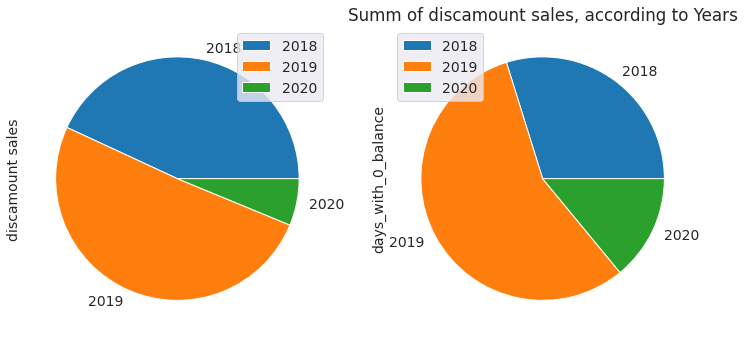

In [37]:
df_pie = df.groupby('Year')[['discamount sales', 
                             'days_with_0_balance']].sum()

# Make the plot with pandas
df_pie.plot(kind='pie', subplots=True, figsize=(12, 8))
plt.title("Summ of discamount sales, according to Years")
plt.show()

We can say that total sales in 2019 more then in a 2018. According to 'days_with_0_balance' it can be say that in 2019 there were more days with zero balance

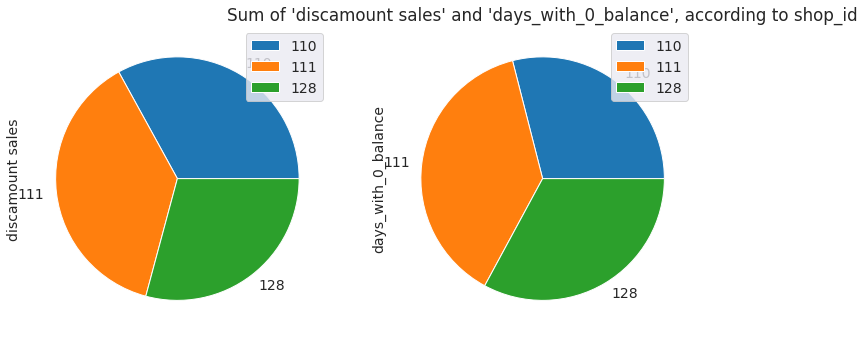

In [38]:
# Form a dataframe using .groupby() method
df_pie_shop_id = df.groupby('shop_id')[['discamount sales', 
                                'days_with_0_balance']].sum()
# A groupby() pandas method is used when we need to group
# large amounts of data and compute some operations on these groups


# Make the plot with pandas
df_pie_shop_id.plot(kind='pie', subplots=True, figsize=(12, 8))
plt.title("Sum of 'discamount sales' and 'days_with_0_balance', according to shop_id")
plt.show()

So, 'discamount sales' are almost equals for all stores

**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

Let's look at the values of Item_cnt_day – the number of sales in pieces. 20 unique values:

In [39]:
df['item_cnt_day'].unique().tolist()

[1, 2, 3, 4, 6, 7, 9, 5, -1, 0, 8, -2, -3, -4, 10, 11, 18, 13, 15, 22]

The data contains negative values - apparently, these are product returns, since the number of sales is a non - negative value.

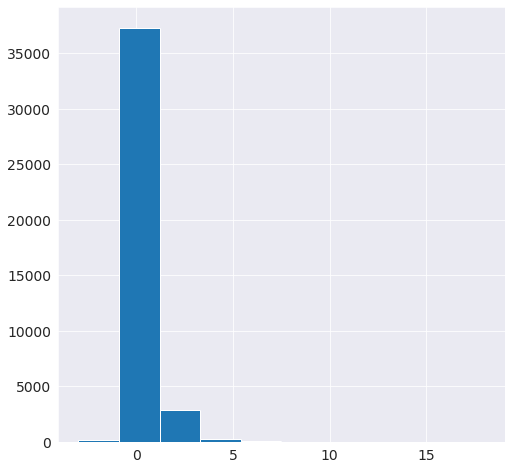

In [40]:
df['item_cnt_day'][df['brand_id'] == 10013].hist(figsize=(8, 8));

So, we can see that most part of days items did not sale in a 10013 store

**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

Plot the barplot graph for brand 10013 for 'Month'

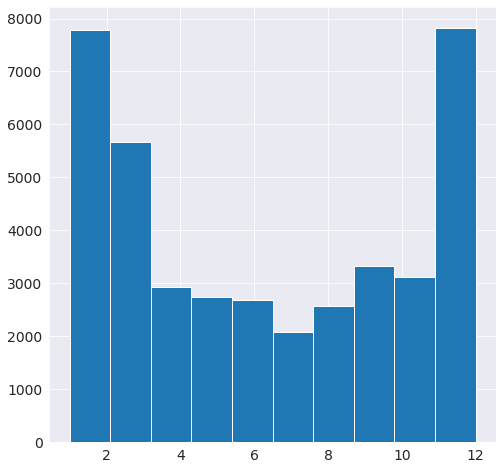

In [41]:
df['Month'][df['brand_id'] == 10013].hist(figsize=(8, 8));

So, least of all sales in a 'July' month, and the most sales are in the winter. The period of occurrence of seasonal fluctuations is more often predicted, and it is influenced by:


*   New year, Christmas, March 8, may and other holidays.
*   In summer, demand is minimal, which is associated with the peak of vacations;
*   Average age, characteristics of the target audience.

**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

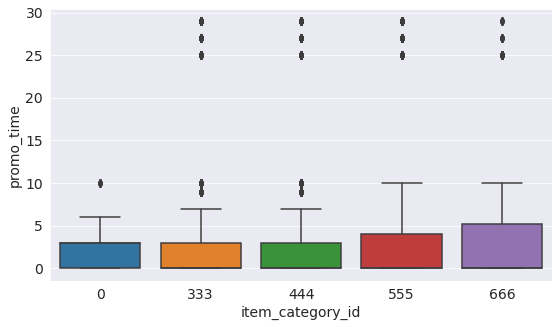

In [42]:
# Explore relationship between columns using scatter plots, bar charts etc.

sns.boxplot(data=df, x='item_category_id', y="promo_time");

Here's what the boxplot shows:

The Median is the value of the element in the center of the ranked row.
For example, if you put all octopuses in ascending order of their ratings, the median will be the rating that the octopus put in the middle. This means that half of the octopuses on the right rated the probability of buying lower, and the other half (on the left) higher than the median.

The upper quartile is a score above which only 25% of the scores are higher.
The lower quartile is a value below which only 25% of estimates are made.
The interquartile range (IQR) is the difference between 75% and 25% quartile. Within this range lies 50% of observations. If the range is narrow (as in the case of octopuses), then the members of the subgroup are unanimous in their assessments. If it is wide, it means that there is no uniform opinion (as in chickens).

Outliers are atypical observations. What exactly is considered atypical? Those estimates that go beyond:

values of 25% percentile minus 1.5 x IQR
values of 75% percentile plus 1.5 x IQR

From the boxplot it is clear, that promo time depends on 'item_category_id'.

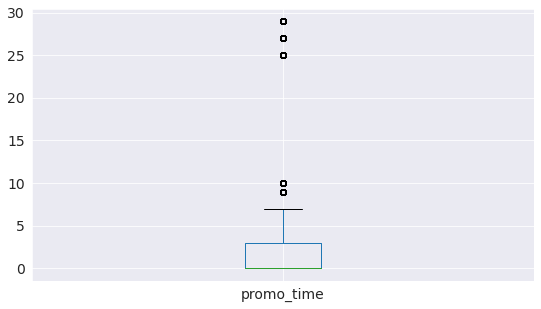

In [43]:
df[["promo_time"]].plot(kind='box');

**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

In [44]:
# Use the built-in corr method()
corr_matrix = df.corr()

Let's look at the Pearson correlation matrix, which is a measure of the degree and positivity of linear relationships between two variables. A value of +1 indicates a direct proportionality between the feature values. If the value is -1, on the contrary, there is a correlation, but with a negative coefficient:

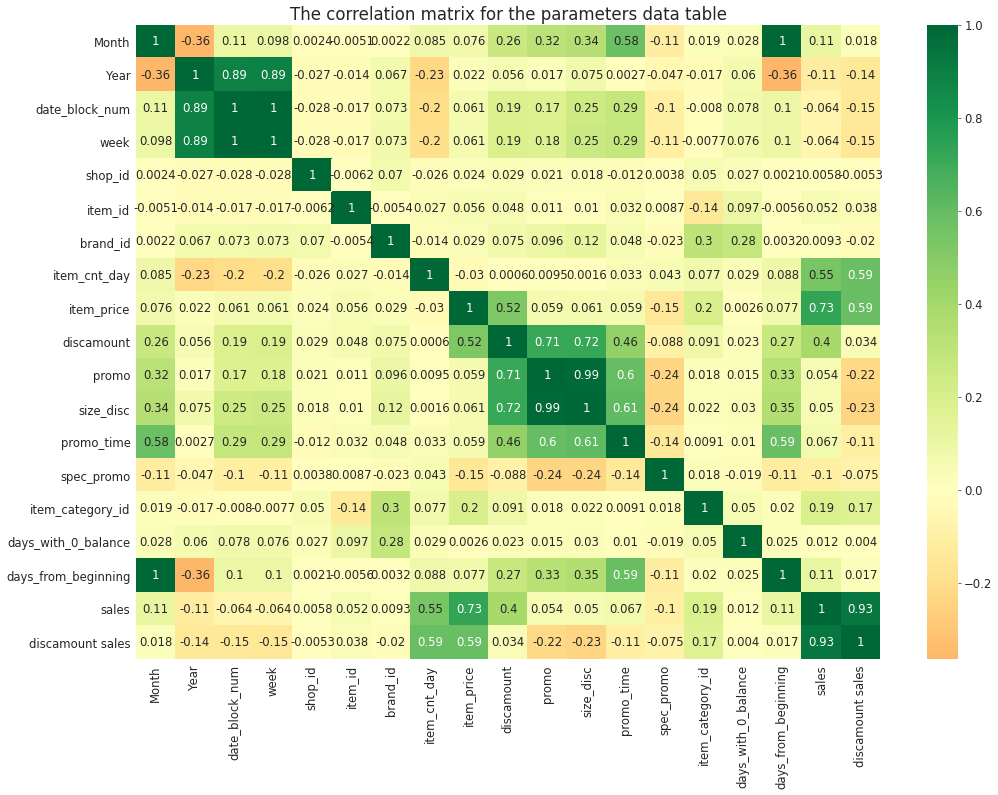

In [45]:
# Pearson graph parameters
plt.figure(figsize=(20,14), dpi=60)
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns, 
            yticklabels=corr_matrix.columns, 
            cmap='RdYlGn', 
            center=0, 
            annot=True)

# Specify additional parameters (the size of the text, the title, and the title itself)
plt.title('The correlation matrix for the parameters data table', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show();

Of course, it would be more correct to build a heatmap for each pair (store, product), which shows how many units of the product were sold during the entire time.

From the correlation table, we can see that the duration of the promo_time discount depends quite strongly on the size of the size_disc (0.61) discount. Also see that having a discount promo (0.71), the value of the discount size_disc (0.72), and duration of action discounts promo_time (0.46) depend on the size of the discount discamount, and is, in principle, so understood that they are interrelated, although the dependence of the duration of the sale size is not obvious. There is also a good correlation of the duration of the promotion from the month (0.58) and slightly less from the day of the week (0.29). This may be due to holidays (new year's), weekends/Fridays, or the holiday period (less people started buying certain products) or seasonality (tanning products are unlikely to be actively bought in the winter, except for those who are going on vacation at this time). Of the negative correlations, the most notable is the dependence of the availability of the promotion on the promo product with a special discount spec_promo (-0.24), that is, the product participating in the simple action cannot participate in the promo action.

Let us save and upload our work to Jovian before continuing

In [46]:
import jovian

In [47]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'

## Asking and Answering Questions

TODO - write some explanation here.



#### Q1: What was the best month for sales in 2018? How much money was earned that month?

In [48]:
# What was the best month for sales in 2018? 
# How much money was earned that month?

df_2018 = df[df['Year'] == 2018].copy()
best_months_2018 = df_2018.groupby('Month')['sales'].sum()
best_months_2018

Month
1      968754
2      874416
3     1456542
4     1112879
5      936021
6      945999
7      923935
8      917823
9     2424834
10    1776066
11    2253456
12    2667638
Name: sales, dtype: int64

In [49]:
print(f"Max profit was on {best_months_2018.index.max()}s moth - it's December")
print(f"And the profit was {best_months_2018.max()} roubles, that is about {best_months_2018.max() // 90}$ in December, 2018")

Max profit was on 12s moth - it's December
And the profit was 2667638 roubles, that is about 29640$ in December, 2018


[ 1  2  3  4  5  6  7  8  9 10 11 12]


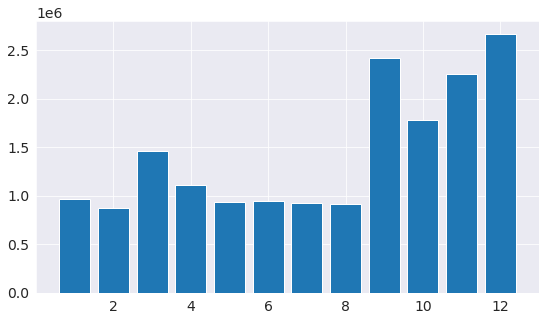

In [50]:
# make values for month using numpy arange() method
months = np.arange(1, 13, 1)
print(months)

plt.bar(months, best_months_2018.tolist());

#### Q2: What are new products wich were added in 2019 year? What are products id's and the number of products that are no longer available in 2019

In [51]:
# List unique goods items in 2018 and 2019 years
items_count_in_2018 = set(df['item_id'][df['Year'] == 2018].unique().tolist())
items_count_in_2019 = set(df['item_id'][df['Year'] == 2019].unique().tolist())

In [52]:
# What are new products wich were added in 2019 year?
print(f"In 2019 were added {len(items_count_in_2019 - items_count_in_2018)} new products")
print(f"Theese are products with id: {items_count_in_2019 - items_count_in_2018}")

In 2019 were added 223 new products
Theese are products with id: {20225856001, 20225856002, 20224960003, 20223168004, 20224064003, 20225856003, 15819328007, 15819328008, 15836352008, 15836352007, 15819328011, 15819328009, 20225856013, 20225856006, 20225856007, 15806336016, 20225856008, 20225856009, 20225856010, 20225856020, 20225856021, 20225856017, 20225856018, 15806336017, 15806336019, 15806336018, 15828736030, 15828736031, 15828736032, 15828736034, 15828736035, 15828736036, 15828736037, 15828736038, 15828736039, 15828736040, 15828736041, 15828736043, 15828736044, 15828736045, 20226192006, 16923760009, 35852544091, 35852544092, 35852544093, 35852544094, 35852544095, 15819328010, 16923760010, 17025456007, 35852544099, 35852544100, 35852544101, 16925776001, 16925776002, 16925776003, 16925776004, 20225744001, 16925776006, 16925776007, 16925776008, 15794128009, 15794128010, 15794128011, 15794128012, 16925776009, 35852880012, 16925888006, 15819664007, 15819664008, 15819328012, 15806336010

In [53]:
# What are products id's and the number of products that are no longer available in 2019?
print(f"The number of products that are no longer available in 2019 is {len(items_count_in_2018 - items_count_in_2019)} pieces")
print(f"these are products with id: {items_count_in_2018 - items_count_in_2019}")

The number of products that are no longer available in 2019 is 278 pieces
these are products with id: {7856128001, 20219584001, 16924992001, 15803200001, 15799616001, 15803200003, 16924992004, 16924992007, 15803200009, 16924992010, 15803200011, 15803200012, 16924992013, 15801408013, 15803200015, 15801408016, 15801408017, 15803200016, 15803200017, 15801408020, 15801408021, 15801408022, 15803200018, 15793792015, 16924544021, 15801408026, 15801072013, 15801408028, 20226192001, 15799168030, 15801520006, 15799168032, 15793344028, 15793344029, 15793344030, 20226192003, 15799168036, 15799168038, 15799168039, 15799168040, 15793344032, 15793344035, 15793344038, 16924096039, 15799168046, 15799168052, 35852544053, 15802304001, 35852544055, 35852544056, 16924096057, 15799056002, 15802304003, 15826048066, 20222384001, 15799056003, 35852544069, 35852544071, 15849792072, 20222384002, 20219136002, 15849792078, 17025456006, 15799056008, 15830192020, 15842064013, 16924544006, 20221824006, 20220368001, 2

#### Q3: What is the best day of week for sales?

In [54]:
df['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [55]:
# First, we should convert 'date' column to datetime using .to_datetime() method
# Agter that is done, we can get day of week by .dt.dayofweek:
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['day_of_week'].head(3)

0    0
1    0
2    0
Name: day_of_week, dtype: int64

In [56]:
df['day_of_week'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [57]:
day_of_week_sales = df.groupby('day_of_week')['sales'].sum()
sales_dict = dict([(sales, i) for i, sales in enumerate(day_of_week_sales)])
sales_dict

{4055636: 0,
 4546639: 1,
 4949366: 2,
 5655539: 3,
 7083199: 4,
 7299629: 6,
 8623858: 5}

In [58]:
max_day_sales = df.groupby('day_of_week')['sales'].sum().max()

print(f"Max sales are {max_day_sales // 90} $ for all time")
print(f"in a {sales_dict[max_day_sales]} day of week")

Max sales are 95820 $ for all time
in a 5 day of week


So, saturday is the best day for sales.

#### Q4: What is the most popular item and what category is it?

In [59]:
# So, to find that out, we should check 'item_cnt_day' column
# and count sum of it, according to 'item_id'
most_popular_item = df.groupby(['item_category', 'item_id'])['item_cnt_day'].sum()

In [60]:
category, item = most_popular_item.idxmax()
category, item

('grooming', 16925552007)

In [61]:
print(f"Most popular item was {item} of {category} category")
print(f"This item was sold {most_popular_item.max()} times")

Most popular item was 16925552007 of grooming category
This item was sold 2178 times


#### Q5: What brand is the most popular? 

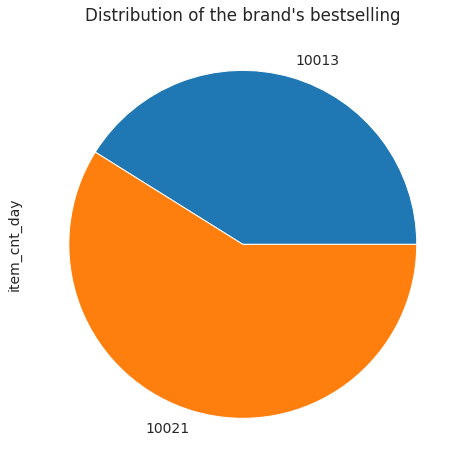

In [62]:
# Form a dataframe using .groupby() method
df_pie_shop_id = df.groupby('brand_id')['item_cnt_day'].sum()
# A groupby() pandas method is used when we need to group
# large amounts of data and compute some operations on these groups

# There are only 2 brands in data
# Make the plot with pandas
df_pie_shop_id.plot(kind='pie', subplots=True, figsize=(12, 8))
plt.title("Distribution of the brand's bestselling")
plt.show()

Brand with id '10021' is more popular, than '10013'.

#### Q6: What are counts of returned items?

In [63]:
print('Total negative values: ', end='')
print(df[df ['item_cnt_day'] < 0]. item_cnt_day.count())
print('Of them equal to -1: ', end='')
print(df[df['item_cnt_day'] == -1].item_cnt_day.count())
print('Of them equal to the value of -2: ', end='')
print(df[df['item_cnt_day'] == -2].item_cnt_day.count())
print('Of them equal to the value -3: ', end='')
print(df[df['item_cnt_day'] == -3].item_cnt_day.count())
print('Of them equal to the value -4: ', end='')
print(df[df['item_cnt_day'] == -4].item_cnt_day.count())

Total negative values: 225
Of them equal to -1: 211
Of them equal to the value of -2: 11
Of them equal to the value -3: 1
Of them equal to the value -4: 2


In other words, in most cases, refunds are single.

Let us save and upload our work to Jovian before continuing.

In [64]:
import jovian

In [65]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'

## Inferences and Conclusion

**TODO** - Write some explanation here: a summary of all the inferences drawn from the analysis, and any conclusions you may have drawn by answering various questions.

First of all, it is worth noting that there is not as much data as we would like to build a high-quality sales forecasting model.
For more accurate and effective sales forecasting, the current data set needs to be enriched with data on the number of days of work in the location - the store may have been under repair, for example, or in quarantine. Bad sales of a location can also be affected by the presence of strong competitors - and sales are always bad there. These, and many other factors, would probably be useful.

You can notice some features of the presented data set: for example, the average duration of promotions (Promo_time) is 5 days (4.801320), and the maximum is about 9 days.
The discount amount varies greatly - from 0 to 50%.

According to distribution by discount values, we can say that most of the values are the absence of a discount, that is, most of the time products are displayed at the usual price, and if a discount is valid, it is usually 50% or 40%.

First of all, we downloaded hand-made by myself Kaggle dataset. Then loaded it into pandas datafraames, and started to concatenate files into one dataframe. After that work is done, we added new columns into dataframe to make it mor consolidated and informative. Finally, we got some statistical inforamtion, answered some interesting questions about data, and plot graphs. In the end, we made conclusions about this work.

In [66]:
import jovian

In [67]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'

## References and Future Work

**TODO** - Write some explanation here: ideas for future projects using this dataset, and links to resources you found useful.

*    For future projects using this dataset, we can predict sales for March of 2020, according to previous sales, that is to make time series analysis: [Forecasting-task Kaggle dataset, tasks, information and more](https://www.kaggle.com/maxinstellar/forecasting-task)

*    Fore time series forecasting exists a lot of solutions, from statistical ones to deep learning methods. You can start from [pytorch-forecasting](https://pypi.org/project/pytorch-forecasting/) library with neural networks.
*    You also can take a try in [LSTM time series prediction](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/). It looks very interesting.
*    And, if you want to have a good understanding of time series analysis, try to read a book [Forecasting principles and practice](https://otexts.com/fpp2/).

Also, I want to thank the team of [Jovian.ml](https://jovian.ml/) for participation in ["Data Analysis with Python: Zero to Pandas"](https://jovian.ml/learn/data-analysis-with-python-zero-to-pandas) project. It was very interesting and informative.

In [68]:
import jovian

In [69]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/max1mka1/sales-forecast-data-exploration


'https://jovian.ml/max1mka1/sales-forecast-data-exploration'